# Search Walk

In [25]:
from qiskit import *
import numpy as np
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.gate import *
import matplotlib.pyplot as plt
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit import Gate
from qiskit.circuit.library import Diagonal

## Useful gate

In [26]:
def grover_oracle(n, sol):
    diagonal_elements = [1]*(2**n)
    diagonal_elements[sol]= -1
    oracle = Diagonal(diagonal_elements)
    oracle.name = "O$_{f}$"
    return oracle.to_gate()

In [27]:
def diffuser(n):
    qr = QuantumRegister(n)
    diffuser = QuantumCircuit(qr)
    
    diffuser.h(qr[:])
    diffuser.x(qr[:])
    diffuser.h(qr[-1])
    diffuser.mct(qr[:-1], qr[-1])  # multi-controlled-toffoli
    diffuser.h(qr[-1])
    diffuser.x(qr[:])
    diffuser.h(qr[:])
    return diffuser.to_gate(label='D')

#diffuser(2).draw(output ='mpl')

In [28]:
def increment_gate(n):
    q_r = QuantumRegister(n)
    inc = QuantumCircuit(q_r)
    for i in range(n-1,0, -1):
        inc.mct(q_r[:i], q_r[i])
    inc.x(q_r[0])
    
    return inc.to_gate(label='INCREMENT')

In [29]:
def decrement_gate(n):
    q_r = QuantumRegister(n)
    dec = QuantumCircuit(q_r)
    
    dec.x(q_r[0])
    for i in range(1,n):
        dec.mct(q_r[:i], q_r[i])
        
    return dec.to_gate(label='DECREMENT')

In [30]:
def shift_gate(n):
    q_r_1 = QuantumRegister(n)
    q_r_2 = QuantumRegister(n)
    q_c = QuantumRegister(2)
    shift = QuantumCircuit(q_r_1, q_r_2,q_c)
    
    dec_j = decrement_gate(n)
    shift.append(dec_j, q_r_1[:])
    
    
    inc_j = increment_gate(n).control(1)
    shift.append(inc_j, [q_c[0]] + q_r_1[:])
    shift.append(inc_j, [q_c[0]] + q_r_1[:])
    
    
    shift.append(inc_j, [q_c[1]] + q_r_1[:])

    
    dec_i = decrement_gate(n).control(1)
    shift.append(dec_i, [q_c[1]] + q_r_2[:])
    
    dec = decrement_gate(n).control(2)
    inc = increment_gate(n).control(2)
    shift.append(inc, q_c[:] + q_r_2[:])
    shift.append(inc, q_c[:] + q_r_2[:])
    shift.append(dec, q_c[:] + q_r_1[:])
    shift.append(dec, q_c[:] + q_r_1[:])
    
    
    shift.x( q_c[1])
        
    return shift.to_gate(label='SHIFT')

#shift_gate(2).draw(output ='mpl')


In [31]:
def negative_gate():

    q_c = QuantumRegister(1)
    neg = QuantumCircuit(q_c)

    N = Operator(np.array([
        [-1, 0],
        [0, -1]
        ]))

    neg.unitary(N, q_c[:])
    return neg.to_gate(label='$-I$')

In [32]:
def oracle(n,i,j, m=2):
    q_r_1 = QuantumRegister(n)
    q_r_2 = QuantumRegister(n)
    q_c = QuantumRegister(m)
    oracle = QuantumCircuit(q_r_1, q_r_2,q_c)
    
    i=bin(i)[2:]
    j=bin(j)[2:]
    #print(i,j)
    
    #print('i =', i)
    
    r = n-len(i)
    #print('r_i=',r)
    for k in range(r):
        oracle.x(q_r_2[n-1-k])
    for k in range(len(i)):
        if i[k]=='0':
            oracle.x(q_r_2[len(i)-1-k])
            
    #print('j =', j)
            
    r = n-len(j)
    #print('r_j=',r)
    for k in range(r):
        oracle.x(q_r_1[n-1-k])
    for k in range(len(j)):
        #print(k)
        if j[k]=='0':
            oracle.x(q_r_1[len(j)-1-k])    
    
    oracle.mct(q_r_1[:]+q_r_2[:], q_c[0])
    oracle.append(negative_gate(), [q_c[0]])
    oracle.append(negative_gate(), [q_c[1]])
    oracle.append(negative_gate(), [q_c[2]])
    
  
    #print('i =', i)
    
    r = n-len(i)
    #print('r_i=',r)
    for k in range(r):
        oracle.x(q_r_2[n-1-k])
    for k in range(len(i)):
        if i[k]=='0':
            oracle.x(q_r_2[len(i)-1-k])
            
    #print('j =', j)
            
    r = n-len(j)
    #print('r_j=',r)
    for k in range(r):
        oracle.x(q_r_1[n-1-k])
    for k in range(len(j)):
        #print(k)
        if j[k]=='0':
            oracle.x(q_r_1[len(j)-1-k])  
  
            
    return oracle.to_gate(label='Oracle')


#oracle(3,2,6, 3).draw(output='mpl')

## Useful functions

In [33]:
def simulate(circuit, shots=1024):
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(circuit, backend = simulator, shots=shots).result()
    counts = result.get_counts(circuit)
    return counts

In [34]:
def grover_dec_bar(n,counts):
    t= 2**(n)
    x= range(t)
    y= [0]*t
    for num in list(counts.keys()) :
        no = int(num, base = 2)
        y[no]+= counts[num]
    y = np.array(y)/sum(y)

    plt.bar(x,y)

In [35]:
def show(n,counts, m=2):
    grid = np.zeros((2**(n),2**(n)))
    for num in list(counts.keys()) :
        i = int(num[m+1:n+m+1], base = 2)
        #i = i if i<2**(n-1) else i-(2**n)
        j = int(num[m+n+2:m+2*n+2], base = 2)
        #j = j if j<2**(n-1) else j-(2**n)
        #print(num, "i ='", i, "',j ='",j,"'", counts[num])
        #grid[i + 2**(n-1)-1,j +2**(n-1)-1]= 1024 - counts[num]
        grid[i,j]+=counts[num]
    print(grid)
    return grid

## Walk on the NxN grid with self-loop

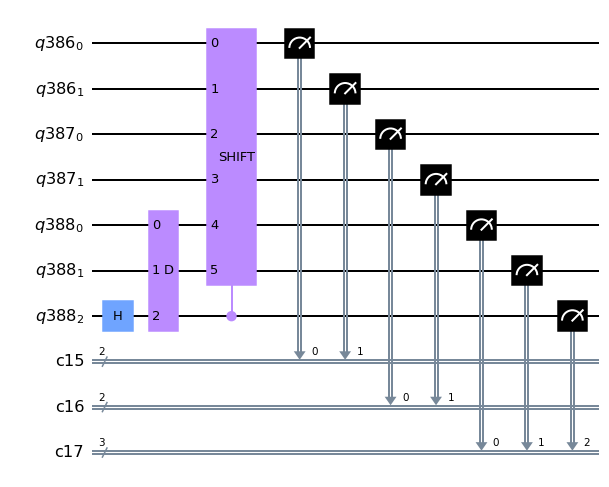

In [36]:
t = 1
n = 2
m=3
i,j = 2,6
q_reg_i = QuantumRegister(n)
q_reg_j = QuantumRegister(n)
q_coin = QuantumRegister(3)
c_reg_i = ClassicalRegister(n)
c_reg_j = ClassicalRegister(n)
c_coin = ClassicalRegister(3)


circuit = QuantumCircuit(q_reg_i, q_reg_j, q_coin, c_reg_i, c_reg_j, c_coin )


circuit.h(q_coin[2])

for _ in range(t) :
    dif = diffuser(3)
    circuit.append(dif, q_coin[:])
    shift = shift_gate(n).control(1)
    circuit.append(shift, [q_coin[2]] + q_reg_i[:] + q_reg_j[:] + q_coin[:2])
    


circuit.measure(q_reg_i[:] + q_reg_j[:] + q_coin[:], c_reg_i[:] + c_reg_j[:] + c_coin[:])

circuit.draw(output ='mpl')

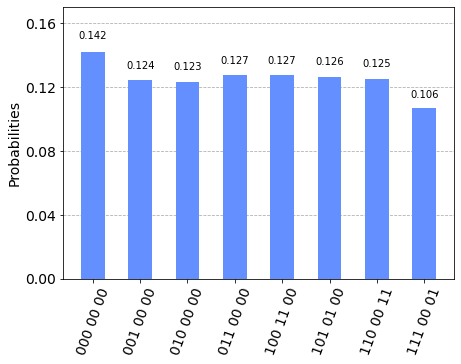

In [37]:
counts = simulate(circuit)
plot_histogram(counts)

[[528. 109.   0. 128.]
 [129.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [130.   0.   0.   0.]]


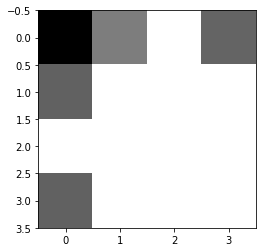

In [38]:
plt.imshow(show(n,counts,3)**(1.1), interpolation='nearest',vmin=0, vmax=1024/3, cmap='binary')

### Search walk on a N-N grid with self-loop

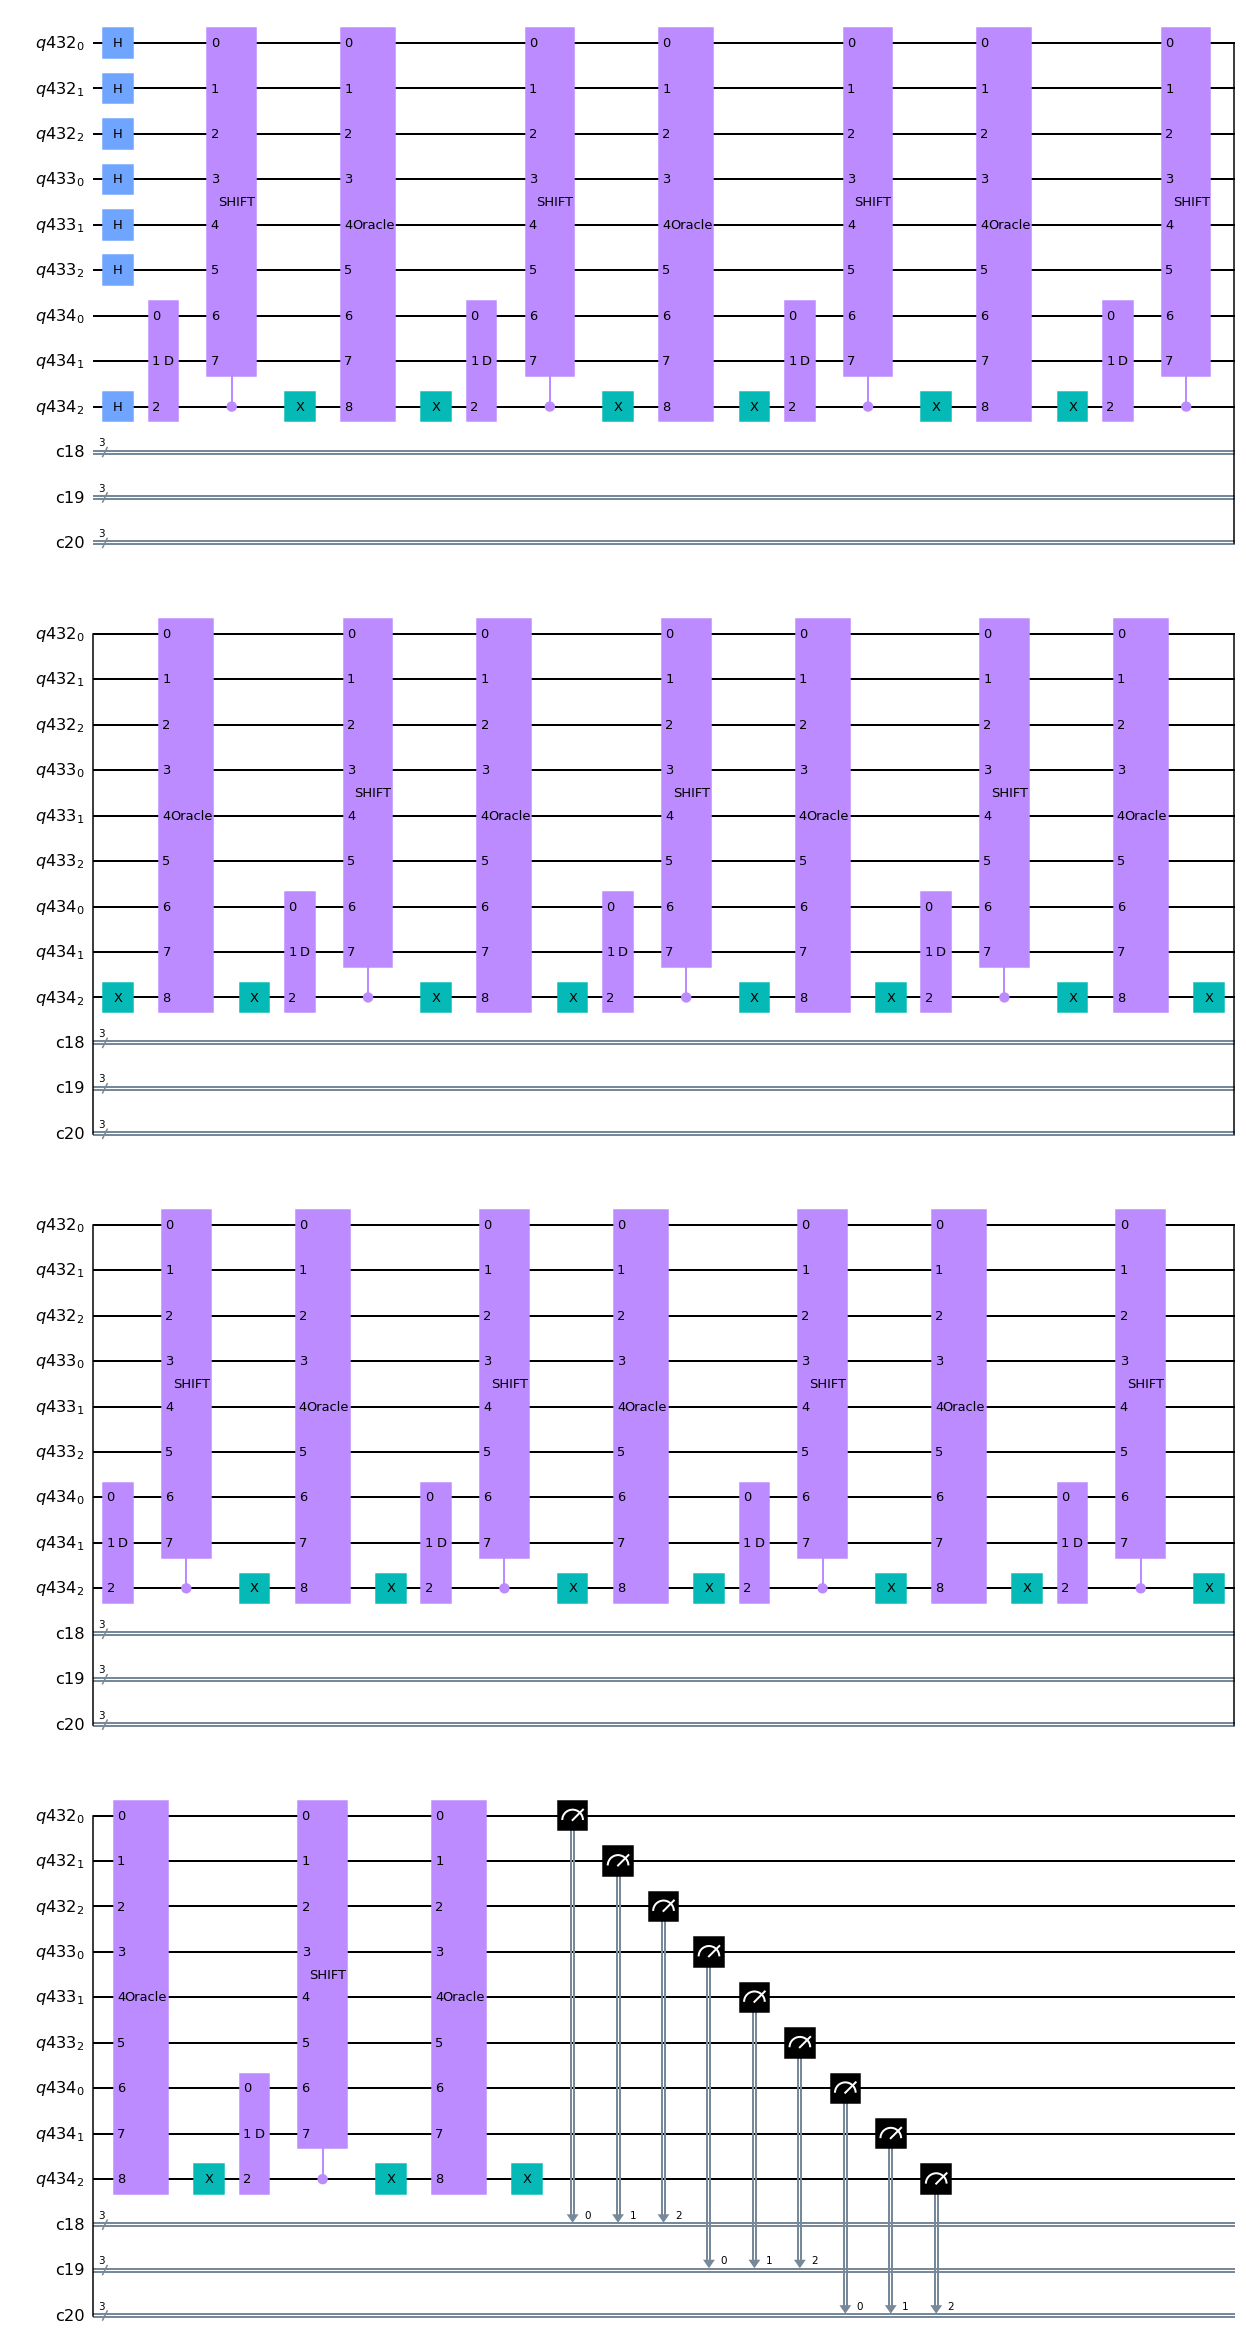

In [39]:
t = 12
n = 3
m=3
i,j = 2,6
q_reg_i = QuantumRegister(n)
q_reg_j = QuantumRegister(n)
q_coin = QuantumRegister(3)
c_reg_i = ClassicalRegister(n)
c_reg_j = ClassicalRegister(n)
c_coin = ClassicalRegister(3)


circuit = QuantumCircuit(q_reg_i, q_reg_j, q_coin, c_reg_i, c_reg_j, c_coin )

circuit.h(q_reg_i[:] + q_reg_j[:])
circuit.h(q_coin[2])

for _ in range(t) :
    dif = diffuser(3)
    circuit.append(dif, q_coin[:])
    shift = shift_gate(n).control(1)
    circuit.append(shift, [q_coin[2]] + q_reg_i[:] + q_reg_j[:] + q_coin[:2])
    circuit.x(q_coin[2])
    oracl = oracle(n,i,j,m)
    circuit.append(oracl ,q_reg_i[:] + q_reg_j[:] + q_coin[:])
    circuit.x(q_coin[2])


circuit.measure(q_reg_i[:] + q_reg_j[:] + q_coin[:], c_reg_i[:] + c_reg_j[:] + c_coin[:])
#circuit.measure(q_coin[:], c_coin[:])
circuit.draw(output ='mpl')

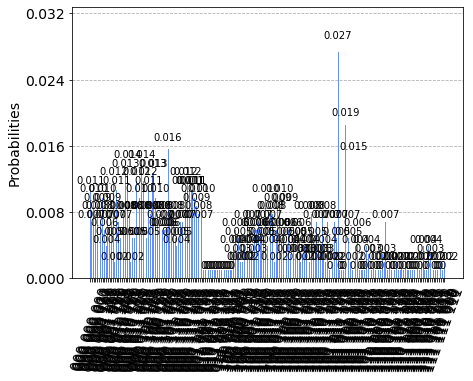

In [40]:
counts = simulate(circuit)
plot_histogram(counts)

[[15. 15. 15. 13. 12.  8. 11. 16.]
 [ 8.  5. 16.  9. 11. 12.  8. 19.]
 [18. 13. 14. 14. 22. 27. 51. 15.]
 [14. 15. 15. 18. 21. 26. 37. 23.]
 [19. 15. 16. 17. 19. 17. 11. 29.]
 [17. 15. 10. 13. 22. 16. 11. 16.]
 [ 7. 15. 11.  9. 15. 16. 14. 21.]
 [16. 16. 19. 12. 11. 11. 14. 18.]]


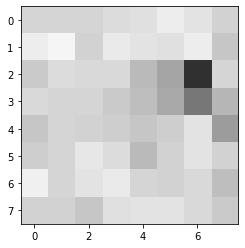

In [41]:
plt.imshow(show(n,counts,3)**(1.3), interpolation='nearest',vmin=0, vmax=1024/5, cmap='binary')